In [1]:
#--------------------------- Importar librerias -------------------------------#

import pandas as pd # Cargar datos CSV
import numpy as np # Arrays
from sklearn.model_selection import train_test_split # División datos
import torch # PyTorch - Redes neuronales
import torch.nn as nn # Definir y entrenar redes neuronales
from torch import optim # Algoritmos de optimización
import torch.nn.functional as F # Funciones de activación
from torch.optim.lr_scheduler import StepLR # Tasa de aprendizaje
from torch.utils.data import DataLoader, TensorDataset # División por lotes
import seaborn as sns # Matriz de confusión
import matplotlib.pyplot as plt # Gráficas
# Métricas de evaluación
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

#-------------------- Cargar los datos desde archivos CSV ---------------------#

# Cargar los datos de entrenamiento
X_train = pd.read_csv('/content/EstrogenReceptorStatus_Train.csv',index_col=0)
# Cargar las etiquetas de los datos de entrenamiento
y_train = pd.read_csv('/content/EstrogenReceptorStatus_Train_labels.txt',header=None)

# Cargar los datos de evaluación
X_test = pd.read_csv('/content/EstrogenReceptorStatus_Test.csv',index_col=0)
# Cargar las etiquetas de los datos de evaluación
y_test = pd.read_csv('/content/EstrogenReceptorStatus_Test_labels.txt',header=None)


In [2]:
#------------------- Convertir los datos a arreglos de numpy ------------------#

# X_train = X_train.to_numpy
X_train = np.asarray(X_train)
# y_train = y_train.to_numpy
y_train = np.asarray(y_train)

# X_test = X_test.to_numpy
X_test = np.asarray(X_test)
# y_test = y_test.to_numpy
y_test = np.asarray(y_test)

#------------------- Mapear los datos a tensores de PyTorch -------------------#

# Convertir los datos de entrenamiento y prueba en tensores
X_train, y_train, X_test, y_test = map(torch.tensor, (X_train, y_train, X_test, y_test))

# Aplanar los tensores - tensores unidimensionales
y_train = torch.flatten(y_train)
y_test = torch.flatten(y_test)

#---------------- Cambiar el tipo de datos de los tensores --------------------#

X_train = X_train.float() # Train - Punto flotante
y_train = y_train.long() # Train labels - entero largo
X_test = X_test.float() # Test - Punto flotante
y_test = y_test.long() # Test labels - entero largo

#-------------------- División de datos 60%, 20%, 20%  ------------------------#

# Dividir los datos en conjuntos de entrenamiento (60%), validación (20%) y prueba (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#---------------------- Cambiar dimensión de etiquetas ------------------------#

# Agregar una dimensión adicional
y_train = y_train.unsqueeze(1)
y_val = y_val.unsqueeze(1)
y_test = y_test.unsqueeze(1)

# Cambiar el tipo de dato a float
y_train = y_train.float()
y_val = y_val.float()
y_test = y_test.float()

In [3]:
#--------------- Definición de la red neuronal feedforward --------------------#

# Se define una red neuronal feedforward con tres capas ocultas y una capa de
# salida con una sola neurona y función de activación Softmax para clasificación binaria

class FFNN(nn.Module):

    #  Inicialización del Modelo #
    def __init__(self):
        super().__init__() # Constructor
        torch.manual_seed(0) # Reproducibilidad

        # Definición de la arquitectura del modelo como una secuencia de capas #
        self.net = nn.Sequential(
            nn.Linear(162, 30), # Primera capa lineal - 162 entradas (características) y 30 salidas
            nn.ReLU(), # Función de activación ReLU - valores negativos a cero y valores positivos sin cambios
            nn.Linear(30, 30), # Segunda capa, transformación lineal - 30 entradas y 30 salidas
            nn.ReLU(), # Función de activación ReLU - valores negativos a cero y valores positivos sin cambios
            nn.Linear(30, 1), # Capa de salida - 30 entradas y 1 salida para clasificación binaria
            nn.Sigmoid() # Función de activación Sigmoide - rango entre 0-1
        )

    # Método Forward - define el paso hacia adelante de la red
    # Pasa el tensor dado X a través de las capas definidas anteriormente en self.net
    def forward(self, X):
        return self.net(X)

    # Método de Predicción
    # Dado un tensor de entrada X, calcula las predicciones de la red neuronal y las devuelve
    def predict(self, X):
        Y_pred = self.forward(X)
        return Y_pred

In [4]:
#- Definición del Bucle de Entrenamiento con Validación, Early Stop y Batches -#

'''
Se crea una función llamada fit_val_earlystop_batches que toma como entrada:

- X_train (los datos de entrenamiento)
- y_train (las etiquetas del entrenamiento)
- X_val (los datos de validación)
- y_train (las etiquetas de validación)
- model (la arquitectura del modelo)
- opt (el optimizador)
- loss_fn (la función de pérdida)
- epochs (el número de épocas de entrenamiento)
- patience (el número de epocas que de no haber mejora, se detiene el entrenamiento)
- batch_sizes (una lista con los tamaños de lote a probar)

Después de completar todas las épocas, la función devuelve 2 diccionarios con el
tamaño de lote como llave y una lista con las pérdidas obtenidas con ese tamaño de lote.
1 diccionario corresponde al entrenamiento y otro a la validación. Además, devuelve
el mejor tamaño de lote.

En caso de cumplirse la condición de Early stoping, se detendrá el entrenamiento y se
regresaran los diccionarios con las pérdidas obtenidas en entrenamiento y validación.

Por cada tamaño de lote probado, se imprimirá a pantalla la época en que se detuvo el
entrenamiento y el número de épocas consecutivas en que la pérdida no mejoró.

Finalmente, se imprimirá a pantalla la mejor pérdida final de entrenamiento y de
validación, así como al tamaño de lote al que corresponden.
'''

# Establecer la semilla para funciones aleatorias de PyTorch
torch.manual_seed(42)

def fit_val_earlystop_batches(X_train, y_train, X_val, y_val, model, opt, loss_fn, epochs, patience, batch_sizes):

    # Diccionarios para almacenar todas las pérdidas
    all_train_losses = {}
    all_val_losses = {}

    # Iteración sobre los tamaños de lote a probar
    for batch_size in batch_sizes:

        # Configurar dataloaders con el nuevo tamaño de lote
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

        # Inicializar el modelo y el optimizador
        model.train()  # Configurar el modelo para entrenamiento
        opt.zero_grad()  # Reiniciar los gradientes del optimizador

        # Listas para almacenar las pérdidas en cada época
        train_losses = []
        val_losses = []

        # Inicializar variables para Early Stopping
        best_val_loss = float('inf')
        epochs_no_improve = 0
        best_model_state = None  # Variable para almacenar el estado del mejor modelo

        # Iteración sobre el número de épocas
        for epoch in range(epochs):
            for batch_X, batch_y in train_loader:
                # Entrenamiento
                model.train()
                train_loss = loss_fn(model(batch_X), batch_y)  # Calculo de la Pérdida
                train_loss.backward()  # Backpropagation
                opt.step()  # Optimización
                opt.zero_grad()  # Reiniciar los gradientes de las variables a 0 (evitar acumulación de gradientes)

            # Validación
            model.eval()
            with torch.no_grad():
                val_loss = 0
                for batch_X_val, batch_y_val in val_loader:
                    val_loss += loss_fn(model(batch_X_val), batch_y_val).item()
                val_loss /= len(val_loader)  # Calcular el promedio de pérdida de validación

            train_losses.append(train_loss.item())  # Almacena la pérdida de entrenamiento actual
            val_losses.append(val_loss)  # Almacena la pérdida de validación actual

            # Implementar Early Stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                # Guardar el estado del mejor modelo
                best_model_state = model.state_dict()
            else:
                epochs_no_improve += 1
                if epochs_no_improve == patience:
                    print(f'Early stopping at epoch {epoch + 1} with batch size {batch_size}')
                    print(f'No se ha observado mejora en {patience} épocas consecutivas.\n')
                    break

        # Cargar el mejor estado del modelo
        model.load_state_dict(best_model_state)

        # Almacenar las mejores pérdidas para el tamaño de lote actual
        all_train_losses[batch_size] = train_losses
        all_val_losses[batch_size] = val_losses

    # Imprimir la mejor pérdida final del entrenamiento y el tamaño de lote al que corresponde
    ultimos_valores = {llave: valores[-1] for llave, valores in all_train_losses.items()} # últimos valores de cada llave
    llave_minima = min(ultimos_valores, key=ultimos_valores.get) # llave con la pérdida final mínima
    print(f"El mejor tamaño de lote para el entrenamiento es  {llave_minima} con una pérdida final de {ultimos_valores[llave_minima]}\n")

    # Imprimir la mejor pérdida final de la validación y el tamaño de lote al que corresponde
    ultimos_valores = {llave: valores[-1] for llave, valores in all_val_losses.items()} # últimos valores de cada llave
    llave_minima = min(ultimos_valores, key=ultimos_valores.get) # llave con la pérdida final mínima
    print(f"El mejor tamaño de lote para la validación es {llave_minima} con una pérdida final de {ultimos_valores[llave_minima]}")

    best_batchsize = llave_minima

    return all_train_losses, all_val_losses, best_batchsize

In [5]:
#--------------------- Establecimiento del Dispositivo ------------------------#

# Establecimiento de CPU como dispositivo
device = torch.device("cpu")

# Transferencia de Datos y Modelo al Dispositivo CPU
X_train=X_train.to(device)
y_train=y_train.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)

# Creación del Modelo y Transferencia al Dispositivo CPU
fn = FFNN()
fn.to(device)

FFNN(
  (net): Sequential(
    (0): Linear(in_features=162, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [6]:
#------------ Definición de hiperparámetros para el entrenamiento -------------#

# Función de pérdida utilizando la entropía cruzada, usada para problemas de clasificación
loss_fn = nn.BCELoss()

# Optimizador - algoritmo de descenso de gradiente estocástico (SGD)
# Tasa de aprendizaje de 0.001
opt = optim.SGD(fn.parameters(), lr=0.001)

# Se establece el número de épocas para el entrenamiento
epocas = 10000

# Se establece la paciencia (numero de épocas donde la pérdida no mejora)
paciencia = 48

# Tamaños de lote a probar
batch_sizes = [16,32,48,64,80,96,112,128,144,160]

In [7]:
#------ Entrenamiento del modelo con validación, Early Stop y Batch_sizes -----#

# Se realiza el entrenamiento aplicando la función
# Y se imprime a pantalla la pérdida mejor final
t3_train_losses, t3_val_losses, best_batchsize = fit_val_earlystop_batches(X_train, y_train, X_val, y_val, fn, opt, loss_fn, epocas, paciencia, batch_sizes)


Early stopping at epoch 469 with batch size 16
No se ha observado mejora en 48 épocas consecutivas.

Early stopping at epoch 69 with batch size 32
No se ha observado mejora en 48 épocas consecutivas.

Early stopping at epoch 1195 with batch size 48
No se ha observado mejora en 48 épocas consecutivas.

Early stopping at epoch 55 with batch size 64
No se ha observado mejora en 48 épocas consecutivas.

Early stopping at epoch 563 with batch size 80
No se ha observado mejora en 48 épocas consecutivas.

Early stopping at epoch 49 with batch size 96
No se ha observado mejora en 48 épocas consecutivas.

Early stopping at epoch 173 with batch size 112
No se ha observado mejora en 48 épocas consecutivas.

Early stopping at epoch 69 with batch size 128
No se ha observado mejora en 48 épocas consecutivas.

Early stopping at epoch 425 with batch size 144
No se ha observado mejora en 48 épocas consecutivas.

Early stopping at epoch 116 with batch size 160
No se ha observado mejora en 48 épocas cons

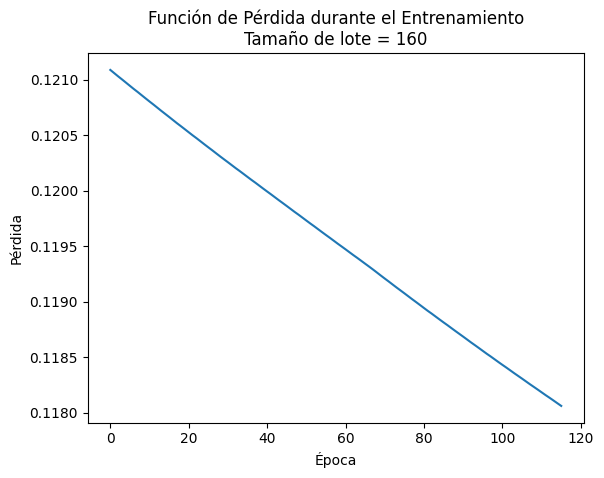

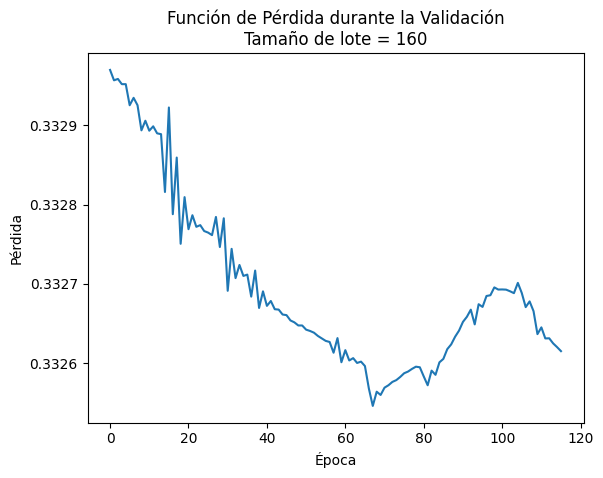

In [8]:
#----------------------------- Función de Pérdida ------------------------------#

# Se generan gráficas para las pérdidas de entrenamiento y validación
# del mejor tamaño de lote

# Entrenamiento
plt.plot(t3_train_losses[best_batchsize])
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title(f'Función de Pérdida durante el Entrenamiento\nTamaño de lote = {best_batchsize}')
plt.show()

# Validación
plt.plot(t3_val_losses[best_batchsize])
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title(f'Función de Pérdida durante la Validación\nTamaño de lote = {best_batchsize}')
plt.show()

In [9]:
#------ Épocas con menor y mayor valor de pérdida en cada tamaño de lote ------#

# Iterar sobre cada tamaño de lote
for size in batch_sizes:

  print(f'Tamaño de lote:{size}\n')

  # Entrenamiento
  train_losses = t3_train_losses.get(size, [])

  print(f'El valor mínimo de pérdida durante el entrenamiento con tamaño de lote {size} fue {min(train_losses)} en la época {train_losses.index(min(train_losses))}')
  print(f'El valor máximo de pérdida durante el entrenamiento con tamaño de lote {size} fue {max(train_losses)} en la época {train_losses.index(max(train_losses))}\n')

  # Validación
  val_losses = t3_val_losses.get(size, [])

  print(f'El valor mínimo de pérdida durante la validación con tamaño de lote {size} fue {min(val_losses)} en la época {val_losses.index(min(val_losses))}')
  print(f'El valor máximo de pérdida durante la validación con tamaño de lote {size} fue {max(val_losses)} en la época {val_losses.index(max(val_losses))}\n\n')


Tamaño de lote:16

El valor mínimo de pérdida durante el entrenamiento con tamaño de lote 16 fue 0.04109667241573334 en la época 461
El valor máximo de pérdida durante el entrenamiento con tamaño de lote 16 fue 1.7775651216506958 en la época 291

El valor mínimo de pérdida durante la validación con tamaño de lote 16 fue 0.46110886335372925 en la época 420
El valor máximo de pérdida durante la validación con tamaño de lote 16 fue 0.6729153792063395 en la época 448


Tamaño de lote:32

El valor mínimo de pérdida durante el entrenamiento con tamaño de lote 32 fue 0.1011974886059761 en la época 32
El valor máximo de pérdida durante el entrenamiento con tamaño de lote 32 fue 2.5962424278259277 en la época 33

El valor mínimo de pérdida durante la validación con tamaño de lote 32 fue 0.42351652681827545 en la época 20
El valor máximo de pérdida durante la validación con tamaño de lote 32 fue 0.6877630949020386 en la época 2


Tamaño de lote:48

El valor mínimo de pérdida durante el entrenami

In [10]:
#------------------ Pérdida final del mejor tamaño de lote --------------------#

print(f'La pérdida final del entrenamiento para el lote de tamaño {best_batchsize} es: {t3_train_losses[best_batchsize][-1]}')
print(f'La pérdida final de validación para el lote de tamaño {best_batchsize} es: {t3_val_losses[best_batchsize][-1]}')

La pérdida final del entrenamiento para el lote de tamaño 160 es: 0.11806139349937439
La pérdida final de validación para el lote de tamaño 160 es: 0.3326150178909302


In [11]:
#--------------------- Función para métricas de evaluación --------------------#

def plot_confusion_matrix(y_true, y_pred_classes):
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_model(model, X, y_true):
    # Obtener las predicciones del modelo
    y_pred = model.predict(X)

    # Calcular la precisión
    y_pred_classes = torch.round(torch.sigmoid(y_pred)).detach().cpu().numpy()
    accuracy = accuracy_score(y_true, y_pred_classes)
    print("Accuracy: {:.4f}".format(accuracy))

    # Visualizar la matriz de confusión como una imagen con seaborn
    plot_confusion_matrix(y_true, y_pred_classes)

    # Calcular y mostrar la curva ROC y el área bajo la curva (AUC)
    y_scores = torch.sigmoid(y_pred).detach().cpu().numpy()[:, 0]
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    print("AUC: {:.4f}".format(auc))

    # Graficar la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


Evaluation on Training Set:
Accuracy: 0.7829


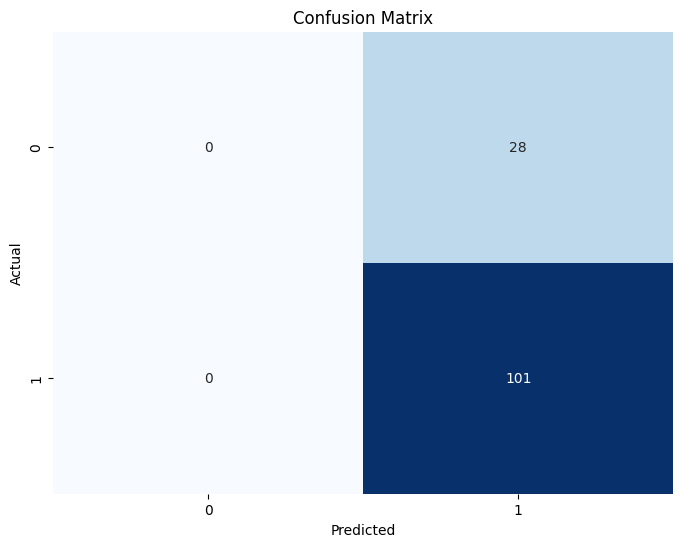

AUC: 0.9767


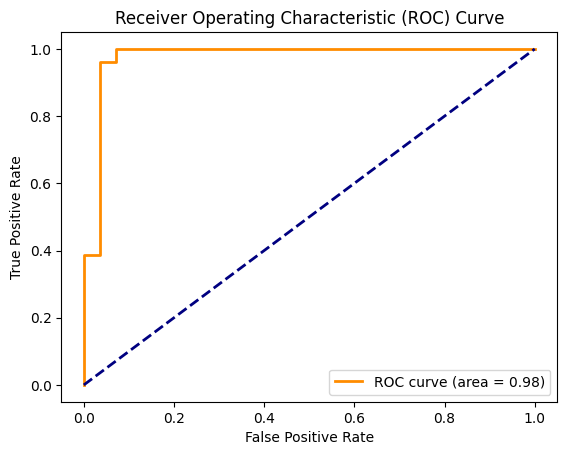

In [12]:
#-----------------. Evaluar en el conjunto de entrenamiento -------------------#

print("Evaluation on Training Set:")
evaluate_model(fn, X_train, y_train)


Evaluation on Test Set:
Accuracy: 0.6818


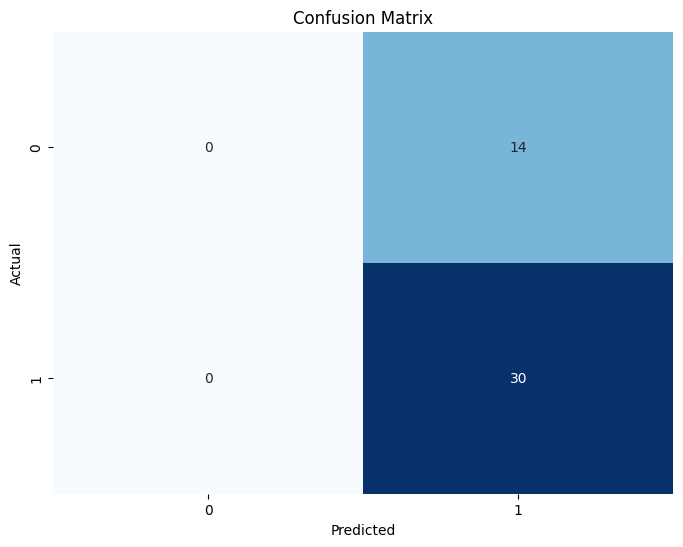

AUC: 0.8857


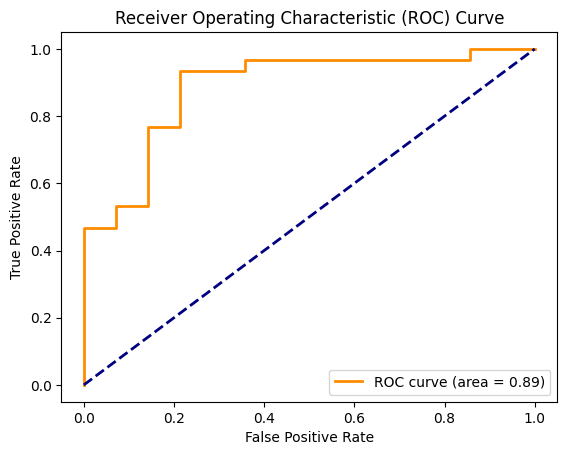

In [13]:
#------------------------ Evaluar en el conjunto de prueba --------------------#

print("\nEvaluation on Test Set:")
evaluate_model(fn, X_test, y_test)